### RTM Scalar Explicit

__________________

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import matplotlib.animation
import matplotlib
import numpy as np
from numba import njit, prange

## Direct or Reverse Modeling


$$ p_{ik}^{n+1} = \beta c_{ik}^2 \left[ -p_{i-2k}^n+16p_{i-1k}^n+16p_{i+1k}^n-p_{i+2k}^n -p_{ik-2}^n+16p_{ik-1}^n+16p_{ik+1}^n-p_{ik+2}^n-60p_{ik}^n \right] +\Delta t^2 c_{ik}^2 \ s_{ik}^n +2p_{ik}^n-p_{ik}^{n-1}  $$

In [3]:
@njit(parallel=True)
def stepScalar(u_tp1, u_t, u_tm1, c, x1, x2, z1, z2, dx, dz, dt):
    """
    Perform a single time step in the Finite Difference solution for scalar
    waves 4th order in space
    """    
    cdz = (dt/dz)**2
    cdx = (dt/dx)**2

    for i in prange(z1, z2):
        for j in prange(x1, x2):
            u_tp1[i,j] = (2.*u_t[i,j] - u_tm1[i,j]
                + (c[i,j]**2)*(
                    cdx*(-u_t[i,j + 2] + 16.*u_t[i,j + 1] - 30.*u_t[i,j] +
                    16.*u_t[i,j - 1] - u_t[i,j - 2])/12. +
                    cdz*(-u_t[i + 2,j] + 16.*u_t[i + 1,j] - 30.*u_t[i,j] +
                    16.*u_t[i - 1,j] - u_t[i - 2,j])/12.))    

##### Abs 2 order

In [4]:
@njit(parallel=True)
def nonreflexive2nd(u_tp1, u_t, u_tm1, c, nx, nz, dx, dz, dt):
    """
    Apply the boundary conditions: free-surface at top, transparent in the borders
    4th order (+2-2) indexes
    Uses Reynolds, A. C. - Boundary conditions for numerical solution of wave propagation problems
    Geophysics p 1099-1110 - 1978
    We apply 1D reynolds at -2/-1 and +2/+1 respectively
    """
    for i in range(nz):
        # left
        for p in range(2):
                u_tp1[i, p] = ( u_t[i, p] + u_t[i, p+1] - u_tm1[i,p+1] +
                (c[i, p]*dt/dx)*(u_t[i, p+1] - u_t[i, p] - u_tm1[i, p+2] + u_tm1[i, p+1])
                )
        #right
        for p in range(2):
            p = 1-p            
            u_tp1[i, nx-2+p] = ( u_t[i, nx-2+p] + u_t[i, nx-3+p] - u_tm1[i, nx-3+p] -
                (c[i, nx-2+p]*dt/dx)*(u_t[i, nx-2+p] - u_t[i, nx-3+p] - u_tm1[i, nx-3+p] + u_tm1[i, nx-4+p])
                )
    # Down
    for i in range(nx):
        for p in range(2):
            p = 1-p
            u_tp1[nz-2+p, i] = ( u_t[nz-2+p, i] + u_t[nz-3+p, i] - u_tm1[nz-3+p, i] -
                    (c[nz-2+p, i]*dt/dz)*(u_t[nz-2+p, i] - u_t[nz-3+p, i] - u_tm1[nz-3+p, i] + u_tm1[nz-4+p, i])
                    )
        # Up
        for p in range(2):            
            u_tp1[p, i] = ( u_t[p, i] + u_t[p+1, i] - u_tm1[p+1, i] +
                    (c[p, i]*dt/dz)*(u_t[p+1, i] - u_t[p, i] - u_tm1[p+2, i] + u_tm1[p+1, i])
                    )

##### Damping Cerjan

$$ e^{-\alpha(i-nx)} $$

In [5]:
@njit(parallel=True)
def applyDamping(array, nz, nx, pad, decay):
    """
    Apply a decay factor to the values of the array in the padding region.
    """
    # Damping on the left
    for i in prange(nz):
        for j in range(pad):
            array[i,j] *= np.exp(-((decay*(pad - j))**2))
    # Damping on the right
    for i in prange(nz):
        for j in range(nx - pad, nx):
            array[i,j] *= np.exp(-((decay*(j - nx + pad))**2))
    # Damping on the bottom
    for i in prange(nz - pad, nz): # down
        for j in range(nx):
            array[i,j] *= np.exp(-((decay*(i - nz + pad))**2))
    # Damping up
    for i in prange(pad): # down
        for j in range(nx): # left-right
            array[i,j] *= np.exp(-((decay*(pad - i))**2))

### original velocity model

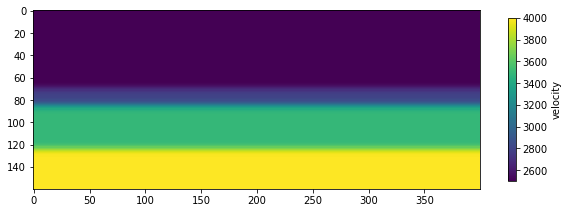

In [6]:
import numpy as np
from PIL import Image
# loading velocity from wedge image file
filename='slab.tif'
img = Image.open(filename)
img.load()
img = img.convert('I') # gray scale, convert format
velocity  = np.asarray(img, dtype=np.float32)
velocity[:][velocity[:] == 255.0] = 2500.0
velocity[:][velocity[:] == 0.0] = 2800.0
velocity[:][velocity[:] == 146.0] = 3500.0
velocity[:][velocity[:] == 36.0] = 4000.0
plt.figure(figsize=(10,5))
im = plt.imshow(velocity)
plt.colorbar(im,  shrink=0.60, pad = 0.05, label=u'velocity')

from scipy.ndimage import gaussian_filter

smoothed = np.zeros(velocity.shape)
sigma = 3 # I have no idea what a reasonable value is here
gaussian_filter(velocity, sigma, output = smoothed)
plt.imshow(smoothed)

velocity = smoothed

### Load shots previously created

dt = 2ms

- Assuming dx=dz=ds=10 m discretization in space in z and x
- 400x10 = 4 km maximum size model
- 9 shots
  - shot spacing 40x10 m = 400 m  
  - split-spread 40 channels each side offsets 10 to 40x10 m = 10 to 400 meters
  - receiver spacing 10 m

In [7]:
shots = np.fromfile('9shots2ms.bin').reshape((1250, 720))

In [8]:
nt, nsp = shots.shape
dt = 2e-3
sz = np.zeros(9, dtype=int)
sx = np.linspace(40, 360, 9, dtype=int)

#### Remove useless data after 800*dt ms 

In [9]:
velocity.shape[0]-40

120

In [10]:
shots = shots[:800, :]
nt = shots.shape[0]

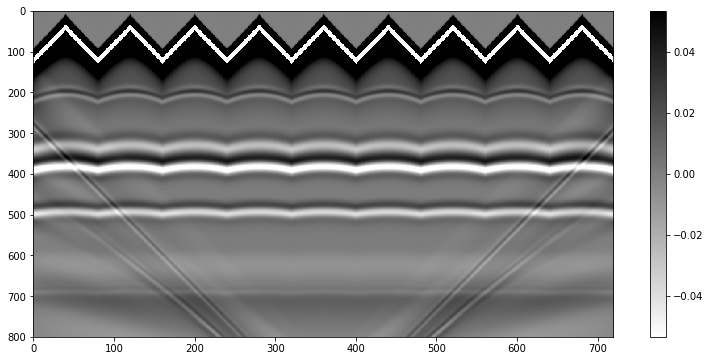

In [11]:
perc = np.percentile(shots, [3])
plt.figure(figsize=(13, 6))
plt.imshow(shots, aspect='auto', vmin=perc[0], vmax=-perc[0], cmap='gray_r')
plt.colorbar()

### Spectrum each trace


- remove direct arrivals
- remove ghost
- remove mean

In [12]:
from scipy.signal import detrend
shots[:260, :] = 0
shots = detrend(shots, type='constant')

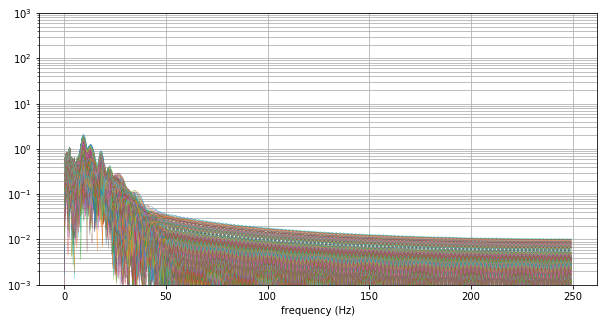

In [13]:
plt.figure(figsize=(10,5))
z = np.abs(np.fft.fft(shots, axis=0))
freqs = np.fft.fftfreq(len(z), dt)
plt.plot(freqs[:len(z)//2], z[:len(z)//2, :], lw=0.3)
#z = np.mean(z, axis=-1)
#plt.plot(freqs[:len(z)//2], z[:len(z)//2], lw=1)
plt.yscale('log')
plt.xlabel('frequency (Hz)')
plt.ylim(1e-3, 1e3)
plt.grid(which='both')


### Remove low frequency noise and anything above 50Hz

In [14]:
from scipy import signal

ny = 1./(2*dt) # nyquest
flow, fhigh = 5./ny, 50/ny # 5 Hz to 50Hz
fir = signal.firwin(255, [flow, fhigh], pass_zero=False)
#b, a = signal.butter(8, flow, btype='highpass')
#shots = signal.filtfilt(b, a, shots, axis=0)

In [15]:
shots = np.apply_along_axis(lambda m: np.convolve(m, fir, mode='same'), axis=0, arr=shots)

## Reverse modeling

Calculate reverse modeling params 

based on:

ds = 10

fmax=45

In [16]:
def params(fcut, c):
    """
    Simulation convergence params
    """    
    # fcut maximum frequency
    f = 2*fcut/(3*np.sqrt(np.pi)) # f central
    td = 2*np.sqrt(np.pi)/fcut # time delay
    lmin = np.min(c)/fcut # lambda min
    ds = 0.95*lmin/5. # grid spacing to avoid spatial alias
    # round to nearest 10 smaller
    ds = int(ds/10)*10
    assert ds < lmin/5. # alford
    dt = (1-1e-4)*ds*np.sqrt(3)/(np.sqrt(8)*np.max(c))  # "quaaase" no limite (menor erro)
    return ds, f, td, dt

# parametros da simulacao fonte de x0 Hz no máxxximoo...
ds, f, td, dt = params(45., velocity)
nt = shots.shape[0]
print('Ds: ', ds, 'f. central :', f, 'delay : ', td, 'dt: ',  dt, ' nt: ', nt)

Ds:  10 f. central : 16.925687506432688 delay :  0.07877572670691181 dt:  0.0015307779961305622  nt:  800


### Resample `shots` to dt of  reverse modeling

In [17]:
import fractions
from scipy import signal
factor=2e-3/dt # resampling factor
frac = fractions.Fraction(factor).limit_denominator(10000)
print('resampling factor | rational aproximational | error')
factor, frac.numerator/frac.denominator, factor-frac.numerator/frac.denominator

resampling factor | rational aproximational | error


(1.306525182002562, 1.306525198938992, -1.693643003619627e-08)

In [18]:
shots = signal.resample_poly(shots, frac.numerator, frac.denominator, axis=0)

C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]


In [19]:
shots.shape

(1046, 720)

In [20]:
nt = shots[0]

### Create array of reinjecting receivers as soucers 
#### Apply gaussian filter to avoid abrubt changes in the beginning

- reverse time shots

In [21]:
receivers = shots[::-1,:]

In [22]:
decay=5e-6
pad=receivers.shape[0]
ix = np.arange(0, pad)
tfilter = np.exp(-(decay*(pad-ix))**2)
for i in range(receivers.shape[1]):
    receivers[:, i] = receivers[:, i]*tfilter

### Receivers as 'sources' to be injected back

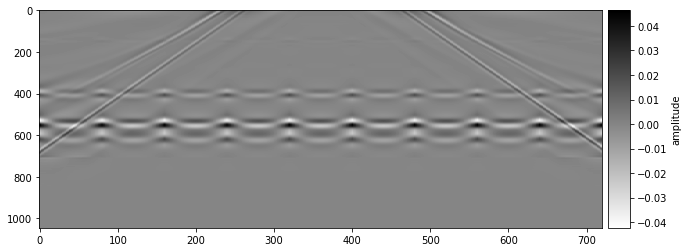

In [23]:
plt.figure(figsize=(12,4))
im = plt.imshow(receivers, aspect='auto', cmap='gray_r')
plt.colorbar(im,  shrink=1, pad = 0.01, aspect=10, label=u'amplitude')

In [24]:
@njit
def injectMultipleSources(u_tp1, c, sz, sx, sources, ns, dt):
    for i in range(ns):
        u_tp1[sz[i],sx[i]] -= ((c[sz[i],sx[i]]*dt)**2)*sources[i]  

### Direct-Reverse Time Simulation Loop for each Shot

In [25]:
@njit
def ricker(t, td, f):
    """amplitude unitária"""
    t = (t - td)
    aux = (1 - 2*(np.pi*f*t)**2)
    return aux*np.exp(-(np.pi*f*t)**2)

def wavemodeling(c, ds, f, td, dt, nt, sz, sx, sources):     
    # model wave 2nd time and 2n space scalar 
    # works for direct modeling or reverse on time    
    if not hasattr(sx, '__len__'): # make as array of one source
        sources = source.reshape(-1, 1)
        sz, sx = np.array([sz]), np.array([sx]) # as array of one source coordinate
        ns = 1
    else:
        ns = len(sx) # number of sources
    npad = 40
    # padd velocity model with border values + 2 addition for 2nd order space derivatives
    padvel = np.pad(c, [npad+2, npad+2],  mode='edge')
    koffset, ioffset = npad+2, npad+2    
    sz, sx = sz+koffset, sx+ioffset # offset due padding and 2nd order borders
    nz, nx = padvel.shape
    p = np.zeros((2, nz, nx)) # n e n+1 ou n-1
    shot_reverse  = np.zeros((nt, nz, nx))
    for i in range(nt):
        # para evitar um painel a mais : pilha de paineis 
        t, tm1 = i%2, (i+1)%2
        tp1 = tm1  
        nonreflexive2nd(p[tp1], p[t], p[tm1], padvel, nx, nz, ds, ds, dt)
        stepScalar(p[tp1], p[t], p[tm1], padvel, 2, nx-2, 2, nz-2, ds, ds, dt)

        applyDamping(p[tm1], nz, nx, npad, 0.004)
        applyDamping(p[t], nz, nx, npad, 0.004)  

        # reinject time sample i recorded in all receivers
        # inject time sample i from all sources
        injectMultipleSources(p[tp1], padvel, sz, sx, sources[i], ns, dt)    
        shot_reverse[i, :, :] = p[t, :, :]
        
    return shot_reverse[:, koffset:-koffset, ioffset:-ioffset] # remove paddings

- Assuming dx=dz=ds=10 m discretization in space in z and x
- 400x10 = 4 km maximum size model
- 9 shots
  - shot spacing 40x10 m = 400 m  
  - split-spread 40 channels each side offsets 10 to 40x10 m = 10 to 400 meters
  - receiver spacing 10 m

In [26]:
velocity.shape

(160, 400)

In [27]:
receivers.shape, sz, sx

((1046, 720),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 40,  80, 120, 160, 200, 240, 280, 320, 360]))

In [28]:
nt = shots.shape[0]

In [29]:
velocity.shape, ds, f, dt, nt

((160, 400), 10, 16.925687506432688, 0.0015307779961305622, 1046)

In [30]:
#receivers[:, i*40:(i+1)*40].shape

In [31]:
from numba import njit, prange, jit

@jit(parallel=True)
def migrate_corr(mshot, rshot):
    "migrate by correlation (not working)"
    nt, nz, nx = mshot.shape
    img = np.zeros((nz, nx))
    for k in prange(nz):
        for i in range(nx):
            tmax = nt-np.argmax(np.abs(np.convolve(mshot[:, k, i], rshot[::-1, k, i], mode='full')))-1
            img[k, i] = rshot[tmax, k, i]
    return img

In [32]:
def migrate_tmax(mshot, rshot):
    tmax = np.argmax(np.abs(mshot), axis=0)
    @njit
    def max_amp(rshot, tmax):
        nt, nz, nx = rshot.shape
        img = np.zeros((nz, nx))
        for i in range(nx):
            for k in range(nz):
                img[k, i] = rshot[tmax[k, i], k, i]
        return img
    return max_amp(rshot, tmax)

In [33]:
mnz, mnx = velocity.shape

In [34]:
@njit
def norm_minmax(arr):
    "normalize to -0.5 to 0.5"
    minv, maxv = np.min(arr), np.max(arr)
    return -0.5 + (arr - minv)/(maxv - minv) 

In [35]:
y = norm_minmax(np.random.rand(10,10))

In [36]:
import tqdm

source = ricker(np.arange(0, nt*dt, dt), td, f) # source for modeling shot
migrated = np.zeros((mnz, mnx)) 
for i in tqdm.tqdm(range(9)):
    s0 = sx[i]-40 #first channel/station
    sn = sx[i]+40 # last channel/station 
    rx = np.array(list(range(s0, sn, 1)), dtype=int) # positions x/i of each receiver for this shot
    rz = np.ones(80, dtype=int)*sz[i] # positions z/j  of each receiver for this shot    
    # model direct shot
    mshot = wavemodeling(velocity, ds, f, td, dt, nt, sz[i], sx[i], source)
    # model reverse shot from receivers # 80 reinjected 'receivers'
    rshot = wavemodeling(velocity, ds, f, td, dt, nt, rz, rx, receivers[:, i*80:(i+1)*80]) 
    shot_migrated = migrate_tmax(mshot, rshot)    
    # detrend migrated shot
    shot_migrated = detrend(shot_migrated, type='constant', axis=0)
    # normalize to -0.5/0.5 amplitudes 
    shot_migrated = norm_minmax(shot_migrated)
    # increment in the migrated image
    migrated += shot_migrated

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:34<00:00,  3.67s/it]


In [37]:
shot_migrated.shape

(160, 400)

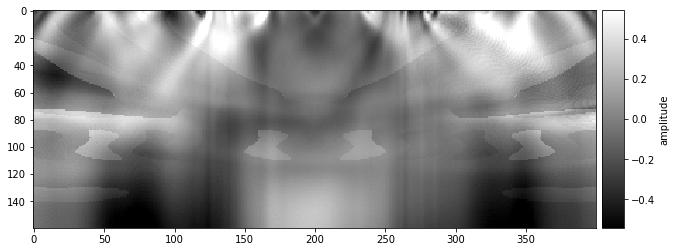

In [44]:
plt.figure(figsize=(12,4))
perc = np.percentile(detrend(migrated, type='constant', axis=0), 1)
im = plt.imshow(detrend(migrated, type='constant', axis=0), 
                aspect='auto', cmap='gray', vmin=perc, vmax=-perc)
plt.colorbar(im,  shrink=1, pad = 0.01, aspect=10, label=u'amplitude')

## Reverse Migrated Section

### overlay velocity model

In [39]:
migrated.shape

(160, 400)

In [40]:
velocity.shape

(160, 400)

In [41]:
#migrated[:50, :] = 0

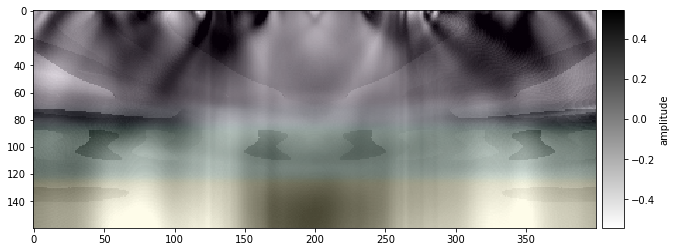

In [45]:
plt.figure(figsize=(12,4))
plt.imshow(velocity, aspect='auto')
im = plt.imshow(detrend(migrated, type='constant', axis=0), 
                aspect='auto', cmap='gray_r', vmin=perc, vmax=-perc, alpha=25)

plt.colorbar(im,  shrink=1, pad = 0.01, aspect=10, label=u'amplitude')